<a href="https://colab.research.google.com/github/FabrizioTroche/eae_ipld_project/blob/main/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees

> Goal of the session:
>
> - At the end of this activity, you will understand the basics of decision tress, how they work internally and how are they used in random forests. Also we will see how models are evaluated and see how can we try to explain the model predictions.
>
> Scope of the session
>
> - Prepare a dataset for training a decision tree model.
> - Analyze the dataset and see how to split it into training and test sets.
> - Train a decision tree model using the `sklearn` library and observe how the trained model inference works.
> - Train a random forest model.
> - See how model performance can be evaluated.

## 1. Setup

### Dependencies

- ``dtreeviz`` 2.2.2
- ``ipython``
- ``nbformat``
- ``numpy`` 2.0.2
- ``pathlib``
- ``plotly`` 5.24.1
- ``pydotplus`` 2.0.2
- ``scikit-learn`` 1.6.1
- ``seaborn`` 0.13.2

In [1]:
%pip install dtreeviz==2.2.2 ipython nbformat numpy==2.0.2 pathlib plotly==5.24.1 pydotplus==2.0.2 scikit-learn==1.6.1 \
    seaborn==0.13.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 782.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00


### Imports

In [2]:
import pickle
from io import StringIO
from pathlib import Path

import dtreeviz
import numpy as np
import plotly.express as px
import pydotplus
import seaborn as sns
from IPython.display import Image
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
iris = datasets.load_iris(as_frame=True)

## 2. Analysis

In [4]:
iris.frame

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


``iris`` is not a dataset, but a collection of datasets (``data``, ``target`` and both merged together as ``frame``).

In [5]:
X = iris.data
y = iris.target

If you notice the name of the variables above, you'll see the X's and y's. Y is that?

In math notation, we define the dataset X as the array of feature vectors, each vector representing the description of a flower in our dataset, each feature representing an aspect of a flower). With all these values in X, we want to infer an approximate function $\hat{y}$, using the labeled dataset in variable `y` to better **fit** the data in `X`.

Or $\hat{y} = f(X)$

Here we also use 'y' as the name of the variable that holds the target variable (species)

In [6]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [7]:
y.to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

<Axes: >

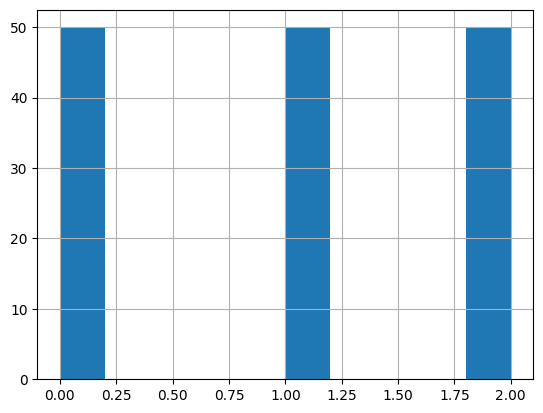

In [8]:
y.hist()

If all the values for the target occur in similar amounts, we can say that the dataset is balanced. If not, we can say that the dataset is unbalanced, which can be an issue.

Do you think this dataset is balanced?

In [9]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [10]:
iris_df = X.copy()
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [11]:
species_dict = {0: "setosa", 1: "versicolor", 2: "virginica"}
iris_df["species"] = y.map(species_dict)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


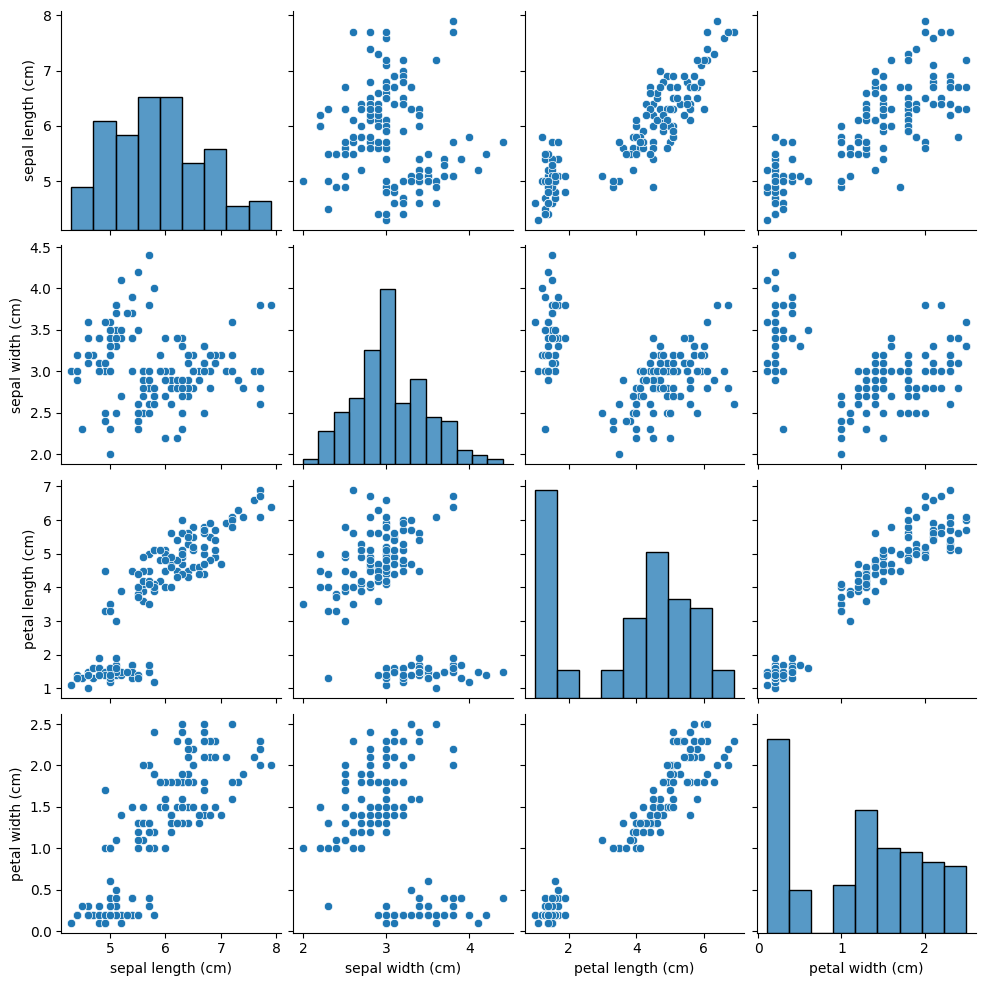

In [12]:
sns.pairplot(iris_df)

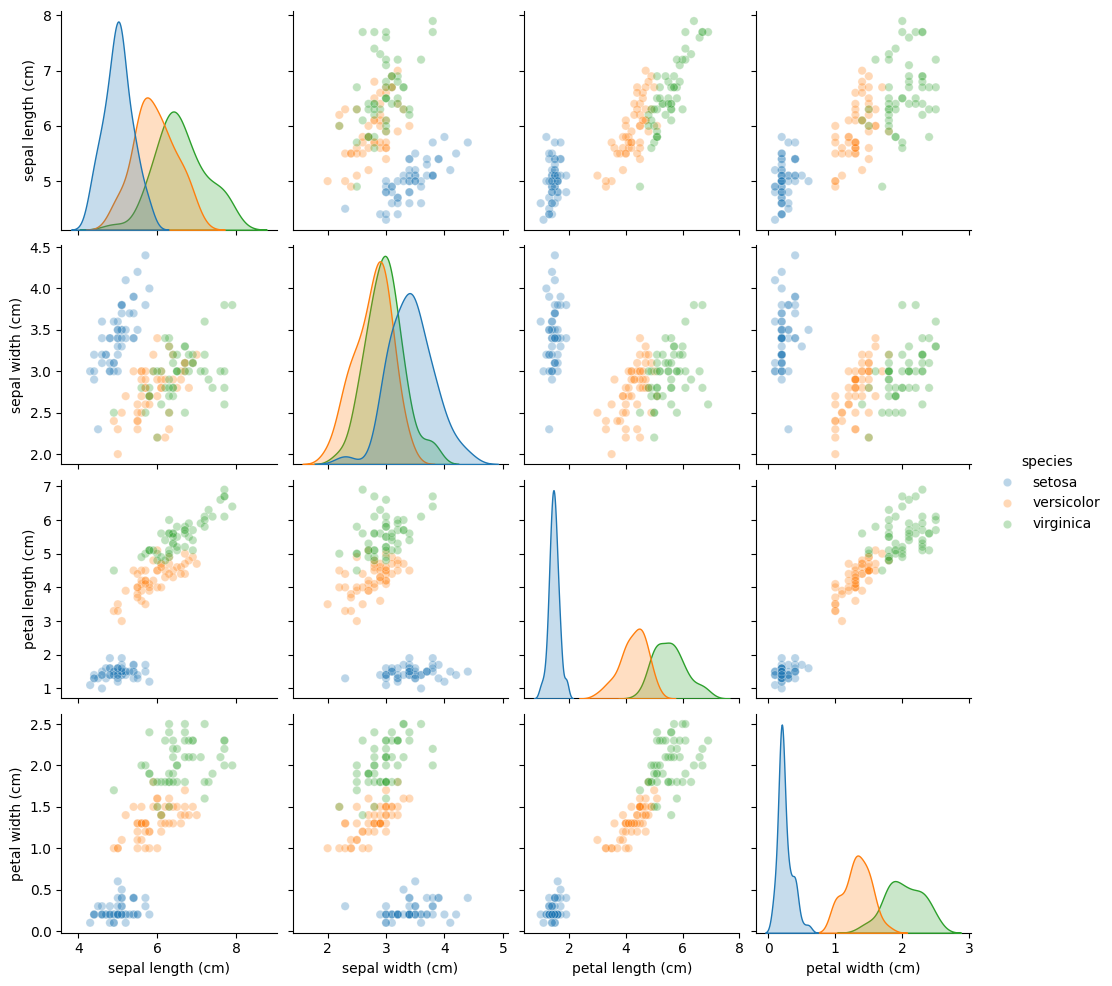

In [13]:
sns.pairplot(iris_df, hue="species", plot_kws={"alpha": 0.3})

<Axes: >

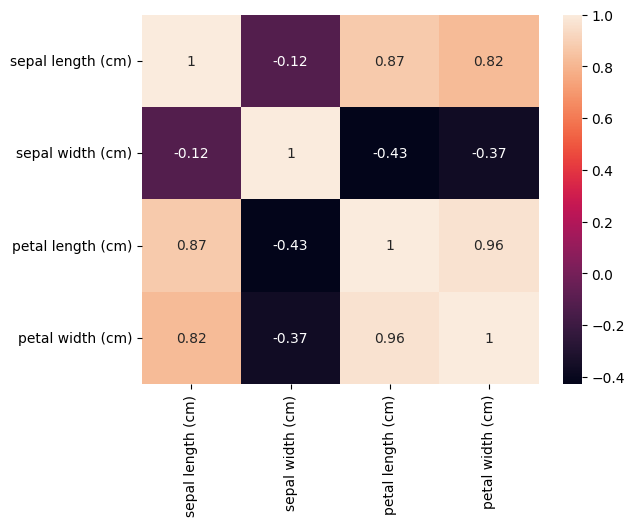

In [14]:
correlation = iris_df.corr(numeric_only=True)
correlation
sns.heatmap(correlation, annot=True)

## 3. Model training

### Dividing the dataset into train and test datasets

We are going to create a decision tree with a partition between train and test of the data. Look at the variable *random_state* that is applied in the `train_test_split` function. By changing this variable, the random distribution between the train and test data will change.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=70, stratify=y)

The random state or seed is a number that is used to initialize the random number generator. It is used to ensure that the random numbers generated are reproducible.

In [26]:
len(X_train)

112

In [27]:
len(X_test)

38

### Why dividing the dataset is important?

You want your model to generalize well, so sampling is important and you need to avoid data leakage, i.e. using the training dataset as the test dataset

Additional resources:
- [K Fold Cross Validation](https://www.datacamp.com/tutorial/k-fold-cross-validation)
- [K Fold Cross Validation in Scikit-Learn](https://www.cloudzilla.ai/dev-education/how-to-implement-k-fold-cross-validation)

### Training a Decision Tree Classifier

In decision trees we're creating structures like:

![](https://miro.com/blog/wp-content/uploads/2021/12/decision_tree_business_analysis.png)

In [28]:
# Create the model
dtree = DecisionTreeClassifier()

# Train the model
# X_train contains the feature vectors for examples of flowers
# y_train contains the classes of these flowers
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

### Exporting model to file

This can be used to create a flower classifier application, for example

In [29]:
# Saves file (serialized dtree object)
with Path("dtree_iris.pkl").open("wb") as f:  # wb stands for Write Binary
    pickle.dump(dtree, f)

> [!Warning]
> Some vulnerabilities have been found in the pickle file format. It can be useful for quickly testing and prototyping, but it is not recommended for production use, where other formats are recommended.

In [30]:
# Just showing the file was actually created
!ls | grep pkl

dtree_iris.pkl


## 4. Analyzing and evaluating the model

### Visualizing resulting decision tree

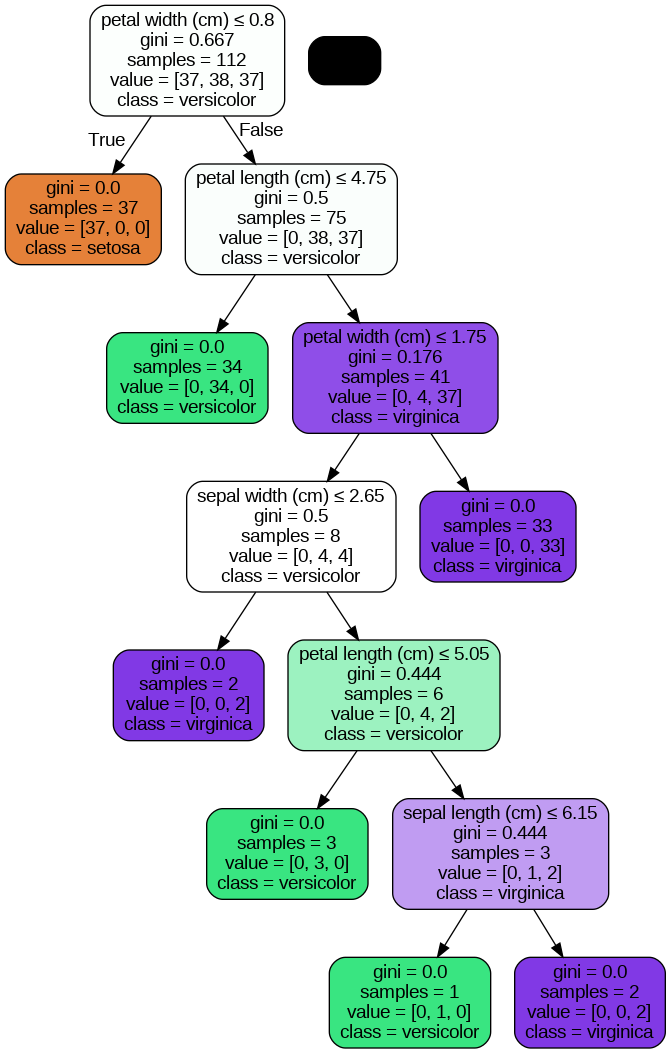

In [31]:
dot_data = StringIO()
export_graphviz(
    dtree,
    out_file=dot_data,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

**Decision Trees** or CART (Classification and Regression Trees):

This method is based on the order of the data. It is, therefore, an iterative method in which each step will try to reduce the *impurity* of the data based on the variable to be predicted. Digging a bit:

1. We start with all our data in the same bag, therefore I have all the different categories mixed together.
By categories we mean the class, the target variable, i.e. what we're trying to predict in a classification task.

    1. The impurity of this data bag is modeled using the **Gini impurity index** (not to be confused with the Gini coefficient).
    1. Simplifying it, it could be seen as: If we introduce a new observation into our bag, whose response variable has been chosen based on the distribution of the different categories, what is the probability of being wrong if I try to classify it?
    1. In other terms: if I have a sack with two pears and two oranges, the impurity is 50%, since a new variable could be with the same probability either pear or orange.

2. Then, as we want to reduce this impurity, we will distribute the observations in different bags in each iteration based on the characteristics of our variables until we obtain groups where there is no possible error: Either everything is pears or everything is oranges.


We can see that there is a variable that strongly marks a first cut, so that already in the first split we obtain a partition without impurity. It is a model capable of obtaining a very accurate division of the data in very few steps.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


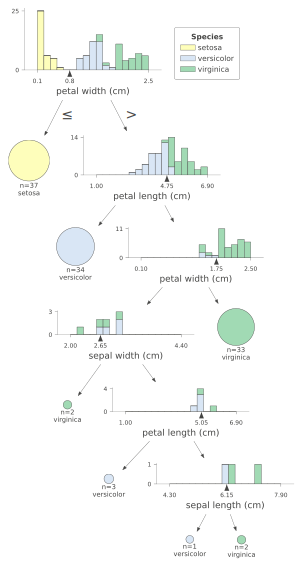

In [32]:
viz = dtreeviz.model(
    dtree,
    X_train,
    y_train,
    target_name="Species",
    feature_names=iris.feature_names,
    class_names=list(iris.target_names),
)

viz.view(fontname="DejaVu Sans")

If we now repeat this process with a different distribution between train and test, which implies that the model has been trained with other data, by changing `random_state` to other value ...

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


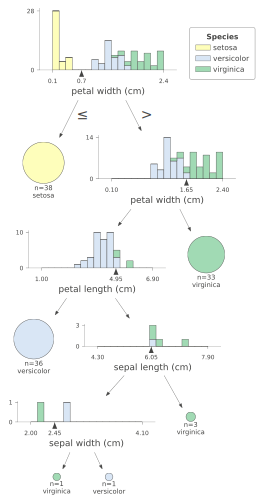

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=60, stratify=y)

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

viz = dtreeviz.model(
    dtree,
    X_train,
    y_train,
    target_name="Species",
    feature_names=iris.feature_names,
    class_names=list(iris.target_names),
)

viz.view(fontname="DejaVu Sans")

### Some words about overfitting and underfitting

Sometimes you train a ML algorithm on the labeled dataset you have, but when faced with new unseen data the model starts performing bad, and therefore making wrong classifications. This happens because the model hasn't generalized the data patterns correctly. It was only replicating the data distribution in a highly specialized or generic way.

![](https://www.mathworks.com/discovery/overfitting/_jcr_content/mainParsys/image.adapt.full.medium.svg/1705396624275.svg)

### Train-validation-test split

One way to try to cope with overfitting is doing a more complex strategy for dividing the dataset into:

1. Train datased: used to train the model
1. Validation (or development) dataset: used to optimize our model parameters to achieve best accuracy possible
1. Test dataset: unseen data separated to test our model with possibly different patterns not found in previous datasets

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

# F-strings https://realpython.com/python-f-strings/
print(f"Training size: {len(X_train)}, Validation size: {len(X_dev)}, Test size: {len(X_test)}")

Training size: 100, Validation size: 12, Test size: 38


In [37]:
# Create the model
dtree = DecisionTreeClassifier()

# Train the model
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


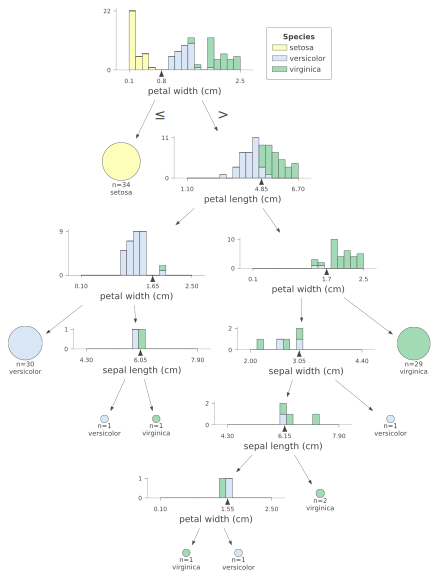

In [38]:
viz = dtreeviz.model(
    dtree,
    X_train,
    y_train,
    target_name="Species",
    feature_names=iris.feature_names,
    class_names=list(iris.target_names),
)

viz.view(fontname="DejaVu Sans")

### Checking accuracy with the validation dataset

In [39]:
y_dev_predicted = dtree.predict(X_dev)
y_dev_predicted

array([2, 0, 2, 2, 2, 0, 1, 1, 1, 2, 0, 0])

In [40]:
print(f"Accuracy with validation dataset {accuracy_score(y_dev, y_dev_predicted)}")

Accuracy with validation dataset 0.9166666666666666


At this point we can do multiple runs of train/validation checks to improve the accuracy score...

### Inferring over new unforeseen data (X_test)

In [41]:
# The same but with X_test, y_test
y_test_predicted = dtree.predict(X_test)
y_test_predicted

array([0, 1, 1, 1, 0, 1, 2, 2, 2, 2, 1, 2, 1, 1, 0, 0, 0, 1, 0, 1, 2, 1,
       1, 1, 2, 1, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 1])

In [42]:
print(f"Accuracy with test dataset {accuracy_score(y_test, y_test_predicted)}")

Accuracy with test dataset 0.9210526315789473


## 5. Decision trees for regression problems

### Diabetes dataset

Target is a quantitative measure of disease progression one year after baseline

![](https://explained.ai/decision-tree-viz/images/samples/diabetes-TD-3-X.svg)

In the above example we can see Decision Trees create **LINEAR** decision boundaries for its variables.
This is amazing to generate (visual) explanations for your resulting model BUT...

What would happen if the feature vector distribution is like in the following image:

![](https://media.geeksforgeeks.org/wp-content/uploads/20200605170732/linearsep.png)

In this case we probably need Support Vector Machines (SVM), which are able to divide the feature space into curved decision boundaries.

### Additional reading

- [A visual introduction to machine learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
- [Understanding Decision Trees with Python](https://www.datacamp.com/tutorial/decision-tree-classification-python)
- [4 Ways to Visualize Individual Decision Trees in a Random Forest](https://towardsdatascience.com/4-ways-to-visualize-individual-decision-trees-in-a-random-forest-7a9beda1d1b7)
- [How to Visualize a Random Forest with Fitted Parameters?](https://analyticsindiamag.com/how-to-visualize-a-random-forest-with-fitted-parameters/)
- [Understanding Random forest better through visualizations](https://garg-mohit851.medium.com/random-forest-visualization-3f76cdf6456f)

## 6. Improving the Model

There are two very useful techniques that allow us to create new models:

* **Bootstrap**: It is based on choosing subsamples of our data in a uniform way and with repetition, thus creating multiple smaller samples that share the distributions of the original sample.

* **Bagging**: Generate a bootstrap of size $n$, train a model on that subsample and repeat the process $m$ times.

## 7. Random Forests

Now let's apply an *ensemble* method such as *Random Forest*, based on the results of multiple decision trees.



There are other types of combining classifiers (or ensemble methods), such as mean average, or the product rule, using a priory probability distributions and the confidence of the classification of each classifier.

Additional reading:

- [Scikit Learn ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html)

### Training a Random Forest

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y)

rf = RandomForestClassifier(n_jobs=-1)  # parallelize the execution
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

Let's analyze the code ... ([RFs in Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

In [44]:
help(rf)

Help on RandomForestClassifier in module sklearn.ensemble._forest object:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  Trees in the forest use the best split strategy, i.e. equivalent to passing
 |  `splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeClassifier`.
 |  The sub-sample size is controlled with the `max_samples` parame

The ``help`` function is very useful to understand the parameters of a function. You can also use the ``?`` operator in Jupyter notebooks to get help on a function.

### Real species

In [45]:
y_test

,target
23,0
58,1
88,1
41,0
30,0
24,0
89,1
106,2
54,1
99,1


### Predicting the class of test dataset

In [46]:
predicted = rf.predict(X_test)
predicted

array([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 2, 1, 0, 2, 2, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 1, 2, 2,
       2, 2, 0, 2, 1, 2])

### Accuracy score

In [47]:
accuracy_score(y_test, predicted)

0.92

In [48]:
help(accuracy_score)

Help on function accuracy_score in module sklearn.metrics._classification:

accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)
    Accuracy classification score.
    
    In multilabel classification, this function computes subset accuracy:
    the set of labels predicted for a sample must *exactly* match the
    corresponding set of labels in y_true.
    
    Read more in the :ref:`User Guide <accuracy_score>`.
    
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) labels.
    
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Predicted labels, as returned by a classifier.
    
    normalize : bool, default=True
        If ``False``, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    
    Ret

### Feature importance

In [49]:
rf = RandomForestClassifier(n_jobs=4)
rf

RandomForestClassifier(n_jobs=4)

In [50]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=4)

In [51]:
importances = rf.feature_importances_
importances

array([0.10963587, 0.01757474, 0.44485635, 0.42793304])

In [52]:
indexes = np.argsort(importances)[::-1]
indexes

array([2, 3, 0, 1])

In [53]:
X.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [54]:
# Map importances to species_names
names = [X.columns[i] for i in indexes]
names

['petal length (cm)',
 'petal width (cm)',
 'sepal length (cm)',
 'sepal width (cm)']

In [55]:
# Prepare a barplot with plotly
fig = px.bar(x=names, y=importances[indexes], labels={"x": "Features", "y": "Importance"}, title="Feature Importance")
fig.show()

In the code of the upper cell we see not only how we can apply a model, but that it contains the importance of the different *features* or predictor variables.

### Predict() function and confusion matrix

In [56]:
rf_preds = rf.predict(X_test)
rf_conf_mat = confusion_matrix(y_test, rf_preds)
rf_conf_mat

array([[17,  0,  0],
       [ 0, 16,  0],
       [ 0,  5, 12]])

In [57]:
help(confusion_matrix)

Help on function confusion_matrix in module sklearn.metrics._classification:

confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
    Compute confusion matrix to evaluate the accuracy of a classification.
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` and
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    
    labels : array-like of shape (n_classes), default=

You can get the accuracy score with data from confusion matrix

In [58]:
# Convert to numpy
np_mat = np.asarray(rf_conf_mat)

acc = sum(np.diagonal(np_mat)) / np_mat.sum()
print(f"My accuracy is: {acc}")

My accuracy is: 0.9


### Confusion matrix visualization

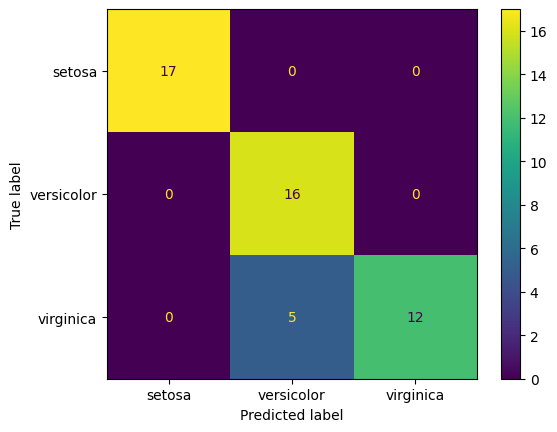

In [59]:
disp = ConfusionMatrixDisplay(confusion_matrix=rf_conf_mat, display_labels=iris.target_names)
disp.plot()